## GANs to generate high-fidelity privacy-safe datasets

### Read Data

In [20]:
import pandas as pd

data = pd.read_csv('D:\Bolsa\dataset\Base.csv')
data.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


### Prepare Data

In [21]:
print(data.columns)
data.drop(['prev_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'], axis=1, inplace=True)
print(data.columns)
data.head()

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')
Index(['fraud_bool', 'income', 'name_email_similarity',
       'current_address_months_count'],
      dtype='object')


,fraud_bool,income,name_email_similarity,current_address_months_count
0,1,0.9,0.166828,88
1,1,0.9,0.296286,144
2,1,0.9,0.044985,132
3,1,0.9,0.159511,22
4,1,0.9,0.596414,218


In [18]:
discrete_columns  = ['fraud_bool']

### Create and Train Model

In [23]:
from ctgan import CTGAN

ctgan = CTGAN(verbose=True)
ctgan.fit(data, discrete_columns, epochs=5)

Epoch 1, Loss G: -1.7611,Loss D: -0.0828
Epoch 2, Loss G: -1.6676,Loss D:  0.0591
Epoch 3, Loss G: -1.6655,Loss D: -0.0017
Epoch 4, Loss G: -1.5717,Loss D:  0.0327
Epoch 5, Loss G: -1.4496,Loss D:  0.0169


### Generate synthetic data

In [24]:
# Create synthetic data
synthetic_data = ctgan.sample(100)

print(synthetic_data.head())

   fraud_bool    income  name_email_similarity  current_address_months_count
0           0  0.600224               0.884260                            84
1           0  0.099833               0.530884                           170
2           0  0.799628               0.100629                            12
3           0  0.800182               0.899478                            46
4           0  0.700049               0.161287                            75


## Test generated data

#### Similarity with real data

(1000000, 4) (100, 4)


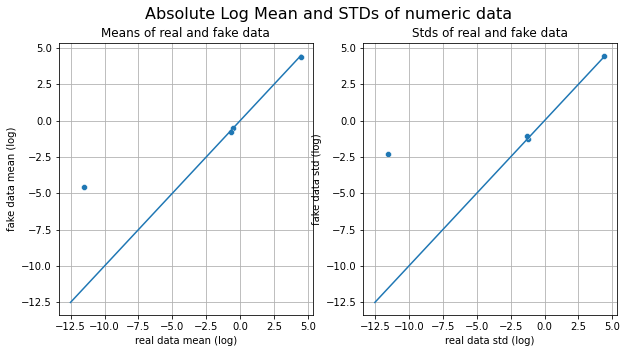

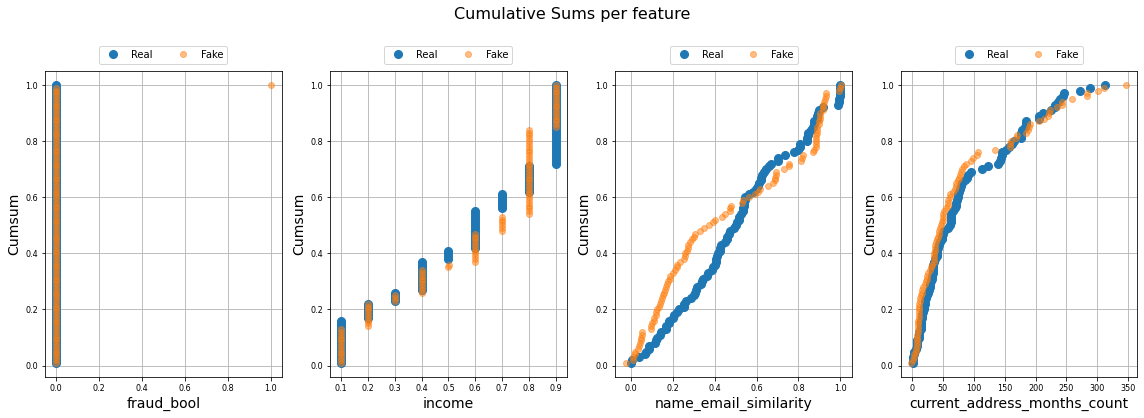

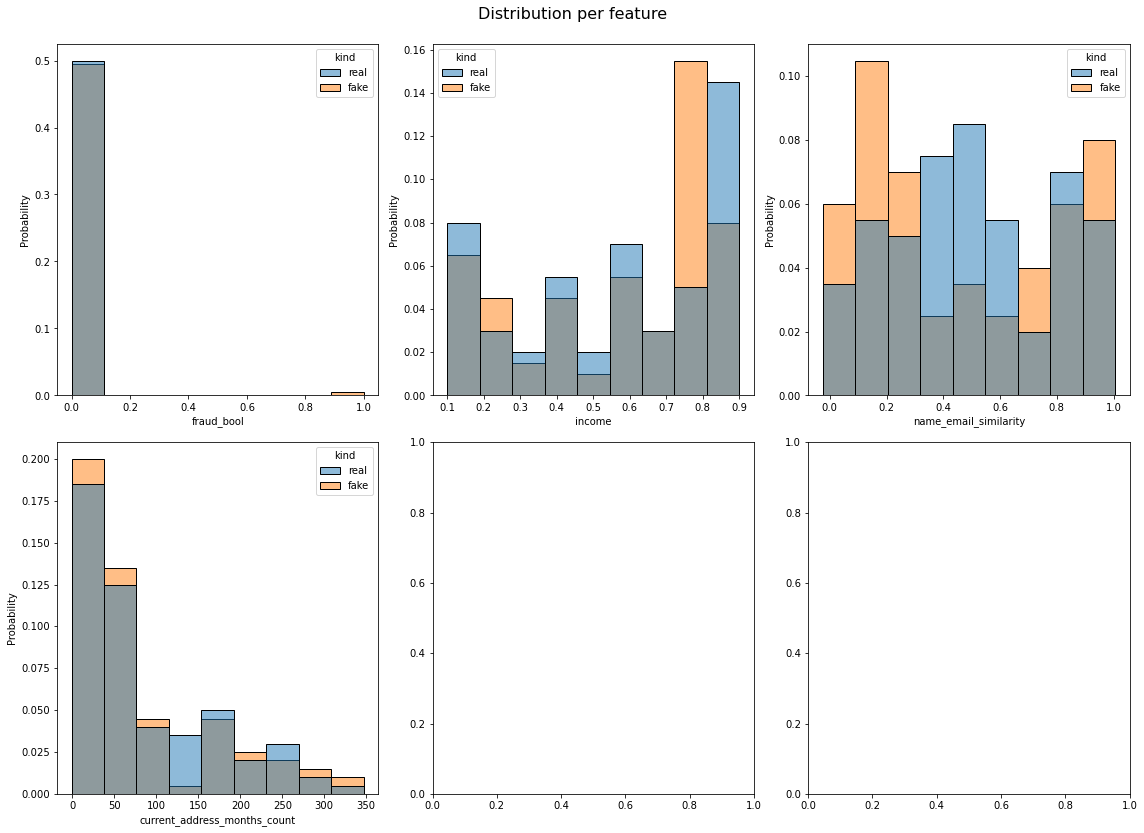

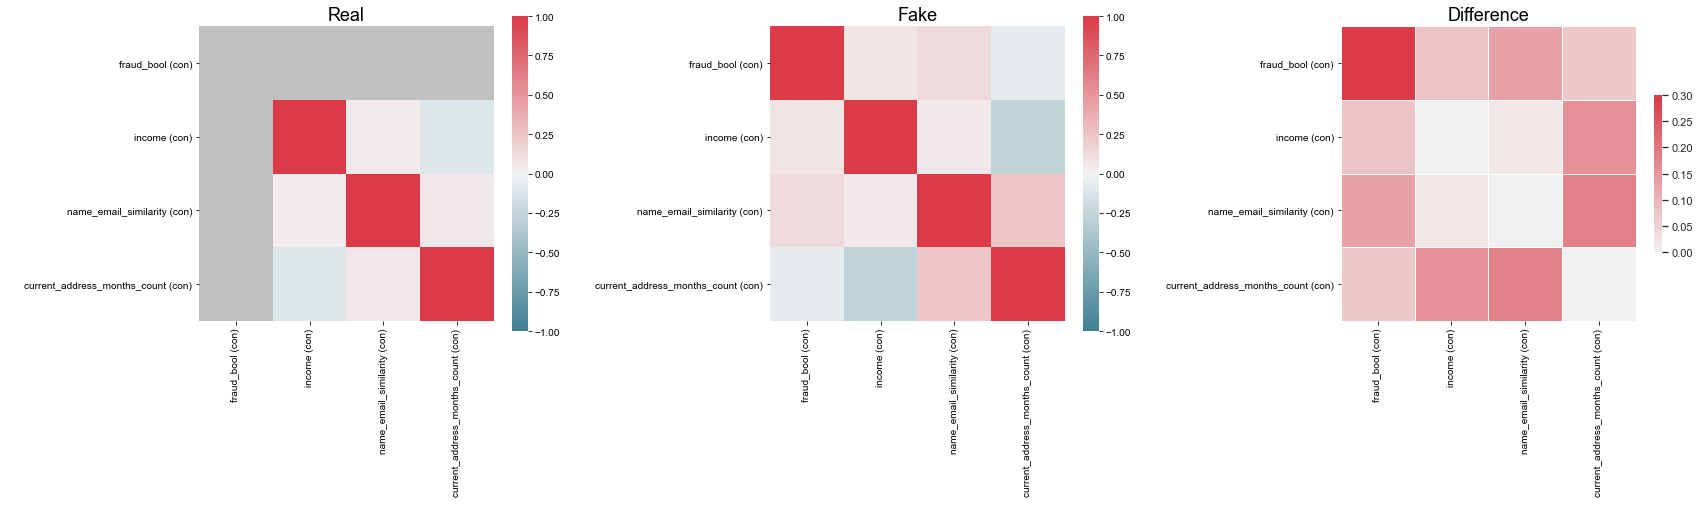

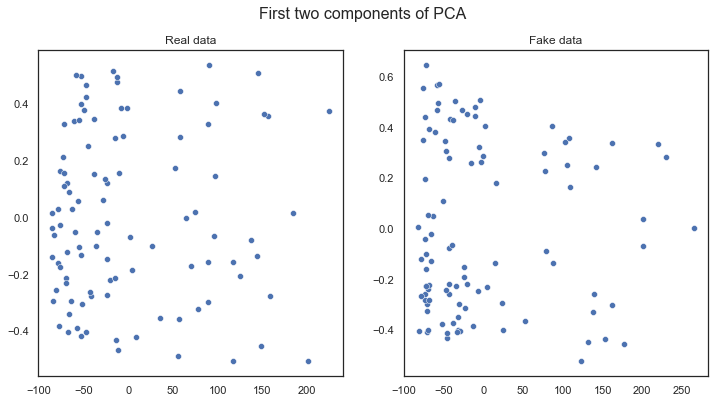

In [26]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, synthetic_data.shape)
table_evaluator =  TableEvaluator(data, synthetic_data, cat_cols=discrete_columns)

table_evaluator.visual_evaluation()

#### Privacy

In [47]:
import pydp as dp
from pydp.algorithms.laplacian import BoundedMean


TypeError: quick_result() missing 1 required positional argument: 'data'

In [65]:
#not working
def typical_mean(column_name):
    return synthetic_data[column_name].mean()

# Calculate mean with differential privacy
def private_mean(column_name, privacy_budget):
    #x = BoundedMean(privacy_budget, synthetic_data[column_name].min(), synthetic_data[column_name].max())
    #x = BoundedMean(0.6, lower_bound=int(synthetic_data['income'].min() * 100000), upper_bound=int(synthetic_data['income'].max() * 100000))
    x = BoundedMean(privacy_budget, lower_bound=1, upper_bound=100000)
    return x.quick_result(list(synthetic_data[column_name]))

true_mean_income = typical_mean('income')
private_mean_income = private_mean('income', 1)

print(f"True mean income: {true_mean_income}")
print(f"Private mean income: {private_mean_income}, 0.8 privacy budget")
print(f"Private mean income: {private_mean('income', 0.1)}, 0.1 privacy budget")

TypeError: result(): incompatible function arguments. The following argument types are supported:
    1. (self: _algorithms.BoundedMeanInt, arg0: List[int]) -> float

Invoked with: <_algorithms.BoundedMeanInt object at 0x0000028EDBC8F070>, [0.6002236724393359, 0.0998332617338163, 0.7996282668260899, 0.8001824536658353, 0.7000485934408245, 0.6998514009402345, 0.9002911550148085, 0.5002901301443703, 0.8003256446489291, 0.19991825976163866, 0.10032330561679843, 0.8002679367469112, 0.19980313549029555, 0.6000364417765179, 0.8000360871314273, 0.799940148871291, 0.09999516676243203, 0.10008919411510958, 0.7996537082756263, 0.5000302692131613, 0.8001451723049238, 0.4000078231742772, 0.7998340531207225, 0.5999149372852599, 0.8001788551871774, 0.6001826073275977, 0.40022036614660117, 0.8999615100719278, 0.8001442675704956, 0.2996436792203131, 0.40027068164536966, 0.9002697293172078, 0.6001686609738823, 0.6002197409418573, 0.6999692331654088, 0.40012429836182833, 0.900121186379654, 0.3000493446936754, 0.7001326049638272, 0.8999184567137636, 0.09985092698946879, 0.8998976361794977, 0.3003398730025686, 0.7997836403106596, 0.7999730350078875, 0.6002390904491786, 0.8000216957063976, 0.8000685631197685, 0.9002106952265087, 0.7002563300232315, 0.9000903481901531, 0.10029262257792218, 0.8005291505306281, 0.8003088589644611, 0.8000470556169039, 0.1999377502846765, 0.1001158493855371, 0.2001792894004828, 0.10047285445467827, 0.9000104978890286, 0.9003228979368523, 0.2002660793429597, 0.6002382910393457, 0.8003002567349615, 0.4002775019462562, 0.39995423656479245, 0.20011280575900822, 0.3999988221643981, 0.10025063143573157, 0.7999876745015602, 0.9001612050375939, 0.8999384551466041, 0.19961400943067278, 0.9001162229440296, 0.09995547053493117, 0.8000770102744313, 0.40013491678899893, 0.6002975217090415, 0.09976219724789326, 0.8003303385316441, 0.19998240142691034, 0.6001639264039124, 0.3997170084410531, 0.8001878706854073, 0.8003002608017461, 0.8000865075927802, 0.8001490655733224, 0.09999856669846388, 0.7998699764884276, 0.6000283974205775, 0.9000392900354004, 0.7997785220641918, 0.8003206544748913, 0.09981581867075759, 0.7001413004173891, 0.9003215562105535, 0.8002686828454593, 0.8001428801504533, 0.1999268263028321, 0.9003404983495371]